In [1]:
import numpy as np
from collections import namedtuple
from matplotlib import pyplot as plt 
from ipywidgets import interact, FloatSlider, IntSlider, fixed, interactive
from filterpy.kalman import predict, update
from filterpy.stats import plot_covariance
from scipy.linalg import inv
%run utils.py

# KALMAN FILTER

1. Introdução à Assimilação de Dados
- Revisão de Estatística e Variáveis Normais
- Kalman Filter Unidimensional
- Revisão sobre Variáveis Normais Multivariadas
- Kalman Filter Multivariado

## Assimilação de dados

**Idéia principal**

Combinar Conhecimento teórico sobre um sistema com dados observados

### Modelo Matemático

Representa conhecimento teórico sobre o sistema

**Modelos de sistemas dinâmicos**

- Utilizam equações de diferenciais e equações de diferença
 - Dependem do estado anterior do sistema
- Modelos são aproximações da realidade
- Viés de projeções - Modelos não são perfeitos!

<center><img src="./fig/07-matrix-1.w570.h712 (2).jpg" style="width: 35% "></center>

## Medição de Dados

- Dados coletados do ambiente real
 - Podem não ser precisos o suficiente

## Exemplo

**GPS de um carro**

- Acurácia pode ser baixa
 - Estimativa de uma região onde o carro pode estar localizado

- Sabemos a região em que o carro estava há um momento atrás

- Sabemos o modelo que descreve o comportamento do carro
 - $\Delta S = S + v \cdot t$

## Exemplo

**GPS de um carro**
- $\Delta S = S + v \cdot t$
- Então, se soubermos a velocidade do carro, podemos prever sua proxima posição aproximada


**Então temos duas fontes fontes de informação!**

- Posição prevista pelo modelo
- Posição estimada pelo GPS

O trabalho do algoritmo de assimilação de dados é unir as duas informações para melhorar a estimativa da posição do carro

## Distinto de machine learning

- Machine learning 
 - Não possuímos nenhum conhecimento prévio do sistema.
 - Aprende apenas pelos dados.
- Assimilação de dados
 - Já conhecemos o comportamento do sistema
 - Geralmente, precisamos de menos informações para ajustar o modelo

# Revisão de Estatística e Variáveis Normais


## **Objetivo: Função Gaussiana**

- Funções Gaussianas são muito utilizadas para representar incertezas no mundo real.

- No Kalman Filter queremos descrever variáveis como funções gaussianas.

<img src="./fig/gausscurve.png" style="width: 400px;">


### **Função de Distribuição Gaussiana**

- Função de distribuição de probabilidade contínua que pode ser descrita através de dois parâmetros,uma média ($\mu$) e uma variância ($\sigma^2$). 

$$ 
f(x, \mu, \sigma) = \frac{1}{\sigma\sqrt{2\pi}} \exp\big [{-\frac{(x-\mu)^2}{2\sigma^2} }\big ]
$$

Quem são os valores que descrevem uma Gaussiana?

### - Média

A média associada a uma função probabilidade é uma tendência de resultados de um evento evento a permanecerem ao redor de um evento médio. "Em média" os resultados de um evento estão próximos da média. Podemos considerar a média como uma previsão de um evento.


### - Variância

A variância associada a uma função de probabildade é o quanto os resultados de um evento se distanciam da média. Quanto maior a variância, menos conhecemos do evento que estudamos e menos precisa é a previsão feita. Quanto menor a variância, mais conhecemos do evento que está sendo estudado e mais precisa é a previsão feita.

Notação para função Gaussiana: ${\displaystyle X\sim {N}(\mu ,\sigma ^{2}).}$ 

- Na função Gaussiana, a probabilidade do evento obter um resultado próximo da média é muito maior do que um resultado longe da média.

<center><img src="./fig/probgaussiana.png" style="width: 50%;"></center>

In [2]:
interact(plot_gaussian,
         x_mean = FloatSlider(value = 0, min = -8, max = 8),
         x_var = FloatSlider(value = 0.6, min = 0, max = 5));

interactive(children=(FloatSlider(value=0.0, description='x_mean', max=8.0, min=-8.0), FloatSlider(value=0.6, …

## **Operações associadas a Gaussianas:**

Para o Filtro de Kalman, vamos utilizar conceitos de operações entre funções Gaussianas de variáveis aleatórias **independentes**.


### - Soma 

Dado dois eventos independentes ${\displaystyle X\sim {N}(\mu
_1 ,\sigma_1 ^{2})}$ e ${\displaystyle Y\sim {N}(\mu_2 ,\sigma_2 ^{2})}$. 

Sua soma resulta em um evento com os parâmetros:

$$\begin{gathered}\mu = \mu_1 + \mu_2 \\
\sigma^2 = \sigma^2_1 + \sigma^2_2
\end{gathered}$$

Essa operação pode ser provada através de convolução.

In [3]:
interact(plot_gaussian_sum,
         x_mean = FloatSlider(value = 0, min = 0, max = 5),
         x_var = FloatSlider(value = 0.6, min = .1, max = 3),
         dx_mean = FloatSlider(value = .4, min = -1, max = 1),
         dx_var = FloatSlider(value = 0.3, min = .1, max = 3));

interactive(children=(FloatSlider(value=0.0, description='x_mean', max=5.0), FloatSlider(value=0.6, descriptio…

### - Multiplicação

Dado dois eventos independentes: ${\displaystyle X\sim {N}(\mu_1 ,\sigma_1 ^{2})}$ e ${\displaystyle Y\sim {N}(\mu_2 ,\sigma_2 ^{2})}$. 

A multiplicação  resulta em uma função gaussiana de parâmetros:
 
$$
\mu =\frac{\sigma_1^2\mu_2 + \sigma_2^2\mu_1}{\sigma_1^2+\sigma_2^2}
$$

$$
\sigma^2 =\frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2}
$$

Essa operação provém da fórmula de Bayes.




- A gaussiana resultante da multiplicação de duas gaussianas independentes sempre terá variância menor do que as variâncias das gaussianas originais. 



- Então, com essa operação você está diminuindo sua incerteza em relação a um novo evento. 


- Para Análise de dados: quanto mais informações você tem sobre um determinado processo, menos incerteza de seu resultado. 



- O Kalman Filter usa essa propriedade matemática de minimização de variância para garantir seus resultados.


In [4]:
interact(plot_gaussian_multiplication,
         x_mean = FloatSlider(value = -2.5, min = -3, max = 3),
         x_var = FloatSlider(value = 0.6, min = 0, max = 3),
         z_mean = FloatSlider(value = 2.5, min = 0, max = 3),
         z_var = FloatSlider(value = 1.1, min = 0, max = 3));

interactive(children=(FloatSlider(value=-2.5, description='x_mean', max=3.0, min=-3.0), FloatSlider(value=0.6,…

# Filtro de Kalman Unidimensional 

<center><img src="./fig/esquema_kf_1.jpg" style="width: 60%"></center>

## Passos Filtro de Kalman 

<center><img src="./fig/data_assimilation.png" style = "width: 50%"></center>

## Passos do filtro de Kalman

<center><img src="./fig/gh_estimate3.png" style="width: 70%"></center>

## Prediction

- Utiliza modelo matemático para prever o estado proximo passo de tempo
 - O resultado da predição é chamado de ***prior***

## Prediction

- Cálculo da média do *prior*

$$\mu = \mu_1 + \mu_2 \quad \to \quad \bar x = x + dx$$

- Cálculo da variância do *prior*

$$\sigma^2 = \sigma^2_1 + \sigma^2_2 \quad \to \quad \bar \sigma_x^2 = \sigma_x^2 + \sigma_{dx}^2$$

Onde:

- $x$ é a média do *posterior* no passo de tempo anterior;
- $\sigma_x^2$ é a variância do *posterior* no passo de tempo anterior;
- $dx$ é o resultado do cálculo da derivada realizado pelo modelo;
- $\sigma_{dx}^2$ é a variância do modelo (e.g. a incerteza da predição).

## Update - Média

- Podemos derivar a fórmula da média de uma 'multiplicação' de duas gaussianas independentes:

$$\mu=\frac{\bar\sigma_x^2\, \mu_z + \sigma_z^2 \, \bar x} {\bar\sigma_x^2 + \sigma_z^2} \quad \to \quad \mu = \left( \frac{\bar\sigma_x^2}{\bar\sigma_x^2 + \sigma_z^2}\right) \mu_z + \left(\frac{\sigma_z^2}{\bar\sigma_x^2 + \sigma_z^2}\right)\bar x$$

Onde:
- $\bar x$ é a média do *prior*
- $\bar \sigma_x^2$ é a variância do *prior*
- $\mu_z$ é o valor da medição
- $\sigma_z^2$ é a variância do sensor

## Update - Média

- Podemos derivar a fórmula da média de uma 'multiplicação' de duas gaussianas independentes:

$$\mu = \left( \frac{\bar\sigma_x^2}{\bar\sigma_x^2 + \sigma_z^2}\right) \mu_z + \left(\frac{\sigma_z^2}{\bar\sigma_x^2 + \sigma_z^2}\right)\bar x$$

$$\mu = W_1 \mu_z + W_2 \bar x \quad \to \quad W_2 = (1 - W_1)$$

$$\begin{aligned}
\mu &= K \mu_z + (1-K) \bar x\\
&= \bar x + K(\mu_z - \bar x)
\end{aligned}$$

- $\bar x$ é a média do *prior*
- $\bar \sigma_x^2$ é a variância do *prior*
- $\mu_z$ é o valor da medição
- $\sigma_z^2$ é a variância do sensor
- K é a proporção chamada de ***Kalman gain***

## Update - Variância
- Também podemos expressar a variância em termos do *Kalman gain*

$$K = \left( \frac{\bar\sigma_x^2}{\bar\sigma_x^2 + \sigma_z^2}\right)$$

$$\begin{aligned}
\sigma^2 &= \frac{\bar\sigma^2 \sigma_z^2 } {\bar\sigma^2 + \sigma_z^2} \\
&= K\sigma_z^2 \\
&= (1-K)\bar\sigma^2 
\end{aligned}$$

## Filtro de Kalman

**Predict**

$$\bar x = x + dx$$
$$\sigma_x^2 = \sigma_x^2 + \sigma_{dx}^2$$

**Update**

$$K = \left( \frac{\bar\sigma_x^2}{\bar\sigma_x^2 + \sigma_z^2}\right)$$
$$\mu = \bar x + K(\mu_z - \bar x)$$
$$\sigma^2 = (1-K)\bar\sigma^2$$

- $\bar x$ é a média do *prior*
- $\bar \sigma_x^2$ é a variância do *prior*
- $\mu_z$ é o valor da medição
- $\sigma_z^2$ é a variância do sensor
- K é a proporção chamada de ***Kalman gain***

In [5]:
def predict(posterior, modelo):
    x, P = posterior # Media e variancia do posterior no passo anterior
    dx, Q = modelo # Media e variancia do modelo
    x = x + dx
    P = P + Q
    return gaussian(x, P)

In [6]:
def update(prior, measurement):
    x, P = prior        # Media e variancia do prior
    z, R = measurement  # Media e variancia do sensor
    
    y = z - x        # Residual
    K = P / (P + R)  # Kalman gain

    x = x + K*y      # Media do novo posterior
    P = (1 - K) * P  # Variancia do novo posterior
    return gaussian(x, P)

In [7]:
def movimento(t, posicao, velocidade):
    return velocidade

In [8]:
# Inicializacao do Modelo
posicao = 0
velocidade = 5 # Velocidade constante
tf = 10
dt = 0.5
Q = 1 # Variancia do modelo
R = 5 # Variancia do sensor

pos_real = [posicao]
zs = [posicao + np.random.normal(0, R)]

for t in np.arange(0, tf, dt):
    # Incrementa posicao
    ruido_sistema = np.random.normal(0, Q)
    posicao = posicao + movimento(t, posicao, velocidade) * dt + ruido_sistema
    pos_real.append(posicao)
    
    # Acrescenta ruido do sensor
    zs.append(posicao + np.random.normal(0, R))

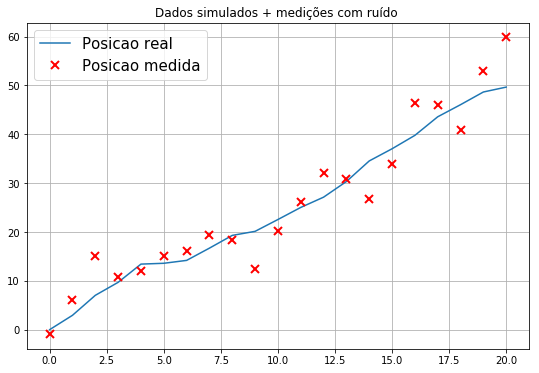

In [9]:
plt.figure(figsize = (9, 6))
plt.plot(pos_real)
plt.plot(zs, 'xr', mew = 2, ms = 8)
plt.grid()
plt.title("Dados simulados + medições com ruído ")
plt.legend(["Posicao real", "Posicao medida"], prop={'size': 15});

In [10]:
# Inicializacao
# Para ilustrar o funcionamento do filtro,
# a posição inicial (posterior[0]) recebe zs[0] + 50
posterior = gaussian(zs[0]+50, R)
predito = []
estimado = []
modelo = []
for z in zs:
    dx = movimento(t, posterior.mean, velocidade) * dt
    
    prior = predict(posterior, gaussian(dx, Q))
    posterior = update(prior, gaussian(z, R))
    
    modelo.append(gaussian(dx, Q))
    predito.append(prior)
    estimado.append(posterior)

In [11]:
interact(plot_kalman_steps, step = IntSlider(1, 1, (int(tf/dt)-1)*4),
        pos_real = fixed(pos_real), modelo = fixed(modelo),
        predito = fixed(predito), estimado = fixed(estimado),
        zs = fixed(zs), R = fixed(R));

interactive(children=(IntSlider(value=1, description='step', max=76, min=1), Output()), _dom_classes=('widget-…

# Gaussianas Multivariadas

## **Objetivo: Função Gaussiana Multivariada**

- Agora estamos interessados em modelar problemas com diversas variáveis. 
- Queremos obter as propriedades matemáticas e operações entre Funções Gaussianas.



## Considerações:



- Tem diversas variáveis de modelo e diversas variáveis medidas.


- Essas variáveis podem ou não interferir no resultado uma da outra.


- A incerteza associada a essas variáveis podem ou não interferir no resultado uma da outra.

Então agora vamos lidar com um conjunto de dados multidimensional. Cada variável de modelo é associada a sua própria média, assim como cada variável medida.:

$
\vec{x} = \begin{bmatrix}x_1\\x_2\\ \vdots \\x_n\end{bmatrix}  $ $\vec{z} = \begin{bmatrix}z_1\\z_2\\ \vdots \\z_n\end{bmatrix}$

Note que agora o resultado do modelo $\vec{x}$ e as medições $\vec{z}$ são caracterizados como vetores.

### **Covariância**


- Agora que consideramos diversas variáveis que podem depender uma das outras, é esperado que a imprecisão de uma afete outra. 


- Na matriz de covariânica guardamos informação da relação de variância entre todas as variáveis.

$$
P = \begin{bmatrix}
  P_1^2 & P_{12} & \cdots & P_{1n} \\
  P_{21} & P_2^2 & \cdots & P_{2n} \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  P_{n1} & P_{n2} & \cdots & P_n^2
 \end{bmatrix}
$$

$$
R = \begin{bmatrix}
  R_1^2 & R_{12} & \cdots & R_{1n} \\
  R_{21} & R_2^2 & \cdots & R_{2n} \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  R_{n1} & R_{n2} & \cdots & R_n^2
 \end{bmatrix}
$$

- Cada elemento dessas matrizes simétricas $P$ e $R$ é uma covariância entre duas variáveis.

In [12]:
interact(interactive_covariance,
         v_a = FloatSlider(value = 2, min = .1, max = 10),
         v_b = FloatSlider(value = 2, min = .1, max = 10),
         v_ab = FloatSlider(value = 0, min = -5, max = 5));

interactive(children=(FloatSlider(value=2.0, description='v_a', max=10.0, min=0.1), FloatSlider(value=2.0, des…

<center><img src="./fig/gaussiancomp.png" style="width: 90%">
</center>

In [13]:
interactive_covariance_multiply = interactive(plot_interactive_covariance_multiply,
         x1 = FloatSlider(value = 2, min = .1, max = 10),
         x2 = FloatSlider(value = 2, min = .1, max = 10),
         x12 = FloatSlider(value = 0, min = 0, max = 5),
         z1 = FloatSlider(value = 2, min = .1, max = 10),
         z2 = FloatSlider(value = 2, min = .1, max = 10),
         z12 = FloatSlider(value = 0, min = 0, max = 5));

In [14]:
interactive_covariance_multiply

interactive(children=(FloatSlider(value=2.0, description='x1', max=10.0, min=0.1), FloatSlider(value=2.0, desc…

# Kalman Filter Multivariado

- **Gaussianas Unidimensionais** substituidas por **Gaussianas Multivariadas**.

- Médias substituídas por **vetor de médias**.
- Variâncias substituídas por **matrizes de covariâncias**.
- Necessidade de adaptar as equações para operações vetor-matriz, utilizando a **álgebra linear**.

## Kalman Filter Univariado VS Multivariado

<center><img src="./fig/pred_update.png" style="width: 70%"></center>

# Variáveis

<center><img src="./fig/variaveis.png" style="width: \linewidth"></center>



# Matriz de Transição (F)

- Recebe um estado e computa previsão para o estado seguinte.

- Forma matricial de equações de diferenças!


# Função de Medições (H)

- Compatilidade de unidades entre medições e variáveis de estado.

- Exemplo: medição de temperatura.


# Variáveis de Controle (b,U)

- u é a variável de controle.
- B é a função de controle.
- Ex. Aceleração.

# Exemplo: Fazendas de Coelhos

<center><img src="./fig/esquema.png" style="width = 40%"></center></center>


Vamos supor o seguinte modelo de equações de diferenças:

$$x_{k+1} = 1.3x_k + 0.1y_k\\
y_{k+1} = 0.2x_k + 1.4y_k $$



que, em forma matricial, pode ser escrito como

$$\left\lbrack\begin{array}{c}
        x_{k+1}\\
        y_{k+1}
        \end{array}\right\rbrack
        = \left\lbrack\begin{array}{cccc}
        1.3 & 0.1 \\
        0.2 & 1.4 
        \end{array}\right\rbrack
        \left\lbrack\begin{array}{c}
        x_k\\
        y_k
        \end{array}\right\rbrack.
$$

Este será o nosso modelo, ou seja, nossa **matriz de transição**

$$ F = \left\lbrack\begin{array}{cccc}
        1.3 & 0.1 \\
        0.2 & 1.4 
        \end{array}\right\rbrack. $$

Vamos supor que temos sensores que medem diretamente o número de coelhos em cada fazenda.

Assim, nossas **variáveis de estado** e **medições** tem a mesma unidade! Tomamos então 

$$ H = \left\lbrack\begin{array}{cccc}
        1 & 0 \\
        0 & 1
        \end{array}\right\rbrack. $$

# Etapas

Da mesma forma que o Kalman Filter Unidimensional, o caso multivariado se divide em três etapas: *inicialização, predict e update*. Vamos entender como cada um deles funciona.

# *Inicialização*

**Ideia:** Fornecer valor de estado inicial e matriz de covariância inicial.

# *Predict Step*

**Ideia:** usar o modelo fazer uma previsão sobre o estado do sistema no próximo intervalo de tempo e estimar o erro associado com essa previsão.

## Passo 1

Usar o modelo para computar o prior $$\mathbf{\bar x} = \mathbf{Fx} + \mathbf{Bu}.$$



## Passo 2

Computar a matriz de covariância do prior $$\mathbf{\bar P} = \mathbf{FPF}^\mathsf T + \mathbf Q. $$

<center><img src="./fig/pred_update.png" style="width: 45%"></center>

# Update Step

**Ideia:** incorporar informações de medidas ao prior, de modo a obter estimativa final para o estado do sistema no próximo intervalo de tempo.




## Passo 1

Obter uma medida $z$ e matriz de covariância $R$ associada a elas.


## Passo 2

Computar o residuo entre o pior e a medida $$\mathbf y = \mathbf z - \mathbf{H\bar{x}}.$$


## Passo 3

Computar fator de escala baseado no que acreditamos ser mais acurado, nosso modelo ou medida 

$$\mathbf K = \frac{\mathbf{\bar{P}H}^\mathsf T }{(\mathbf{H\bar{P}H}^\mathsf T + \mathbf R)} .$$


## Passo 4

Usar o fator de escala para obter a estimativa final(posterior). 

$$x  = \bar{\mathbf x} + \mathbf{Ky}$$

## Passo 5

Combinar a matriz de covariância do prior e das medidas para calcular a matriz de covariância associada ao posterior

$$\mathbf P = (\mathbf{I}-\mathbf{KH})\mathbf{\bar P}.$$

<center><img src="./fig/pred_update.png" style="width: 80%"></center>

## Exemplo: Fazenda dos Coelhos

Vamos agora implementar o filtro para o exemplo dos coelhos. Lembre-se que tinhamos o sistema:

$$\left\lbrack\begin{array}{c}
        x_{k+1}\\
        y_{k+1}
        \end{array}\right\rbrack
        = \left\lbrack\begin{array}{cccc}
        1.3 & 0.1 \\
        0.2 & 1.4 
        \end{array}\right\rbrack
        \left\lbrack\begin{array}{c}
        x_k\\
        y_k
        \end{array}\right\rbrack.
$$



E concluímos que


$$ F = \left\lbrack\begin{array}{cccc}
        1.3 & 0.1 \\
        0.2 & 1.4 
        \end{array}\right\rbrack ~~~~\mathrm{e}~~~~
 H = \left\lbrack\begin{array}{cccc}
        1 & 0 \\
        0 & 1
        \end{array}\right\rbrack. $$
  

## Geração das Variáveis do Modelo

In [15]:
#Número inicial de coelhos em cada fazenda.
x = np.array([10, 13])

# Matriz de Covariância incial associada à estimativa de número de coelhos em cada fazenda.
P = np.diag([1, 1])

#Função de Transição
F = np.array([[1.3, 0.1], [0.2, 1.4]])

#Matriz de Covariância do Processo 
Q = cov_matrix(4, 4, -.95)

#Measurement Function
H = np.array([[1,0], [0,1]]) 

#Matriz de Covariância dos Sensores. Supomos que covariância é zero. Ou seja, um sensor não influencia no outro.
R = np.array([[150,0], [0,150]])

## Geração das Observações e da Curva do Modelo

In [16]:
teo = []
zs = []
t0 = 0; tf = 11
t = np.linspace(t0, tf, tf)

for i in t:
    q = np.random.multivariate_normal(mean = [0,0], cov = Q)
    x = F @ x + q
    teo.append(x.copy())

    z = np.random.multivariate_normal(mean = [0,0], cov = R)
    zs.append(x + z)

teo = np.asarray(teo)
zs = np.asarray(zs)

## Implementação do Kalman Filter Multivariado

In [17]:
# x inicial para o filtro de Kalman.
x = np.array([zs[0,0], zs[0,1]]) 



n = len(zs) #número de observações
pred, xs, cov = [], [], []
for z in zs:
    # predict
    x = F @ x
    P = F @ P @ F.T + Q
    pred.append(x.copy())
    
    #update
    S = H @ P @ H.T + R
    K = P @ H.T @ inv(S)
    y = z - H @ x
    x += K @ y
    P = P - K @ H @ P
    
    xs.append(x.copy())
    cov.append(P.copy())

pred, xs, cov = np.array(pred), np.array(xs), np.array(cov)

In [18]:
def plot_coelhinhos(teo, zs, pred, xs, dono, ax):
    #Plota os valor Estimados, Observações e Modeo

    ax.plot(t,teo, '-.C4', label = ('Teorico. ' + dono))
    ax.plot(t,zs, 'xC3', label = ('Observado (z). ' + dono))
    ax.plot(t,pred, '.C2', label = ('Predito (Prior). ' + dono))
    ax.plot(t,xs, 'C0', label = ('Estimado (Posterior). ' + dono))
    ax.set_xlabel('Tempo')
    ax.set_ylabel('Número de Coelhos')
    ax.grid()
    ax.legend()
    

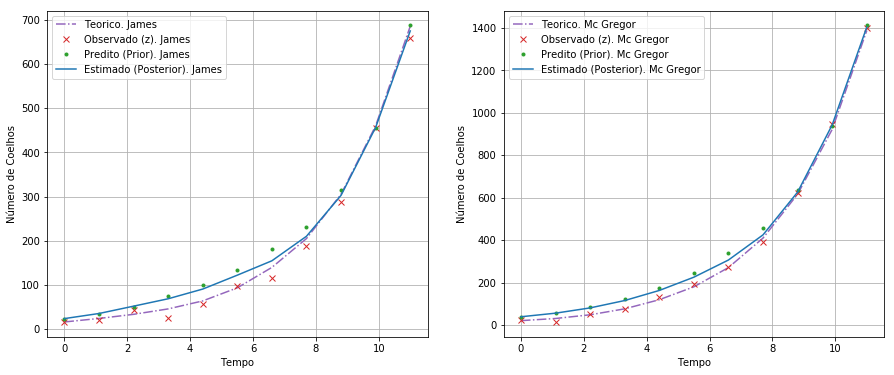

In [19]:
fig = plt.figure(figsize = (15, 6))
ax = plt.subplot(121)
plot_coelhinhos(teo[:,0], zs[:,0], pred[:,0], xs[:,0], "James", ax)
ax = plt.subplot(122)
plot_coelhinhos(teo[:,1], zs[:,1], pred[:,1], xs[:,1], "Mc Gregor", ax)

## Alguns Outros Casos Possíveis

# CASO 2

**Modelar (x):** número de coelhos em cada fazenda.

**Medições (z):** número de coelhos na Fazenda do Jones.




$$\textbf{y} = \mathbf z - \mathbf{H\bar x}$$

$$
\begin{aligned}
\begin{bmatrix}\mathrm{Resíduo} \end{bmatrix} &= \begin{bmatrix}\mathrm{Coelhos~Jones}\end{bmatrix} - \begin{bmatrix}?&?\end{bmatrix} \begin{bmatrix} \mathrm{Coelhos~Jones}\\ \mathrm{Coelhos~Mc~Gregor}\end{bmatrix}
\end{aligned}
$$



Note que $z$ é dado em Coelhos de Jones. Assim, o produto $H\overline{x}$ deve também ter essa unidade. Assim, tomamos $H = \begin{bmatrix}1&0\end{bmatrix}$.

### CASO 3

**Modelar (x):** número de coelhos em cada fazenda.

**Medições (z):** kg de ração consumido em cada fazenda.

$$\textbf{y} = \mathbf z - \mathbf{H\bar x}$$

$$
\begin{aligned}
\begin{bmatrix}\mathrm{Resíduo} \end{bmatrix} &= \begin{bmatrix}\mathrm{Kg~Ração~Jones}\\\mathrm{Kg~Ração~Mc~Gregor}\end{bmatrix} - \begin{bmatrix}?&?\\?&?\end{bmatrix} \begin{bmatrix} \mathrm{Coelhos~Jones}\\ \mathrm{Coelhos~Mc~Gregor}\end{bmatrix}
\end{aligned}
$$



Vamos considerar que cada coelho come, teoricamente, $0.2kg$ de ração por dia na fazenda do Jones e $0.3kg$ de ração por dia na fazenda do Mc Gregor. Então, tomamos $H = \begin{bmatrix}0.2&0\\0&0.3\end{bmatrix}$.

### CASO 4

**Modelar (x):** número de coelhos em cada fazenda.
**Medições (z):** kg de ração consumido na fazenda do Jones.



$$
\begin{aligned}
\textbf{y} &= \mathbf z - \mathbf{H\bar x}  \\
\begin{bmatrix}\mathrm{Resíduo} \end{bmatrix} &= \begin{bmatrix}\mathrm{Kg~Ração~Jones}\end{bmatrix} - \begin{bmatrix}?&?\end{bmatrix} \begin{bmatrix} \mathrm{Coelhos~Jones}\\ \mathrm{Coelhos~Mc~Gregor}\end{bmatrix}
\end{aligned}
$$



Note que $z$ é dado em Coelhos de Jones. Assim, o produto $H\overline{x}$ deve também ter essa unidade. Assim, tomamos $H = \begin{bmatrix}0.2&0\end{bmatrix}$.


In [20]:
# %%HTML
# <style>

# .container {
#     width: 85% !important;
# }

# .rendered_html {
#   font-size: 0.73em;
# }
# .rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
#      font-size: 100%;
# }

# # .CodeMirror {
# #     font-size: 1em;
# # #     width: 100vw;
# # }

# .prompt{
#     display: None;
# }

# # .output {
# #     align-items: center;
# # }

# div.output_subarea {
#     max-width: 100%;
# }

# </style>

%%HTML
<style>

.CodeMirror {
    width: 100vw;
}

.container {
    width: 85% !important;
}

.rendered_html {
  font-size: 1.4vw;
}
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}

.CodeMirror {
    font-size: 0.8vw;
}

.prompt{
    display: None;
}

</style>